# **Name: Aditya Mishra | Roll Number: 21013 | Course: DSE-312 Assignment-2**

# **Connecting to the Directory**

In [1]:
%cd /content/drive/MyDrive/Computer Vision/Assignment-2

/content/drive/MyDrive/Computer Vision/Assignment-2


# **Question-1**

# **(a)**

(960, 1440)


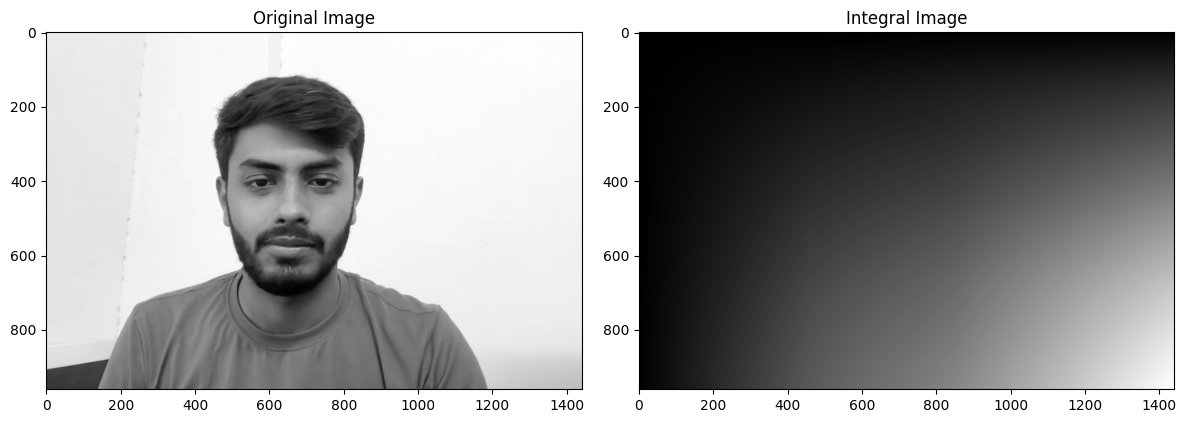

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

# Load the image from drive
image = io.imread('/content/drive/MyDrive/Computer Vision/Assignment-2/image-webcam.jpeg', as_gray=True)
img = np.array(image)
print(img.shape)

# Function to calculate the integral image
def calculate_integral_image(img):
    integral_image = np.zeros_like(img, np.float64)
    integral_image = np.pad(integral_image, ((1, 1), (1, 1)), 'constant', constant_values=0)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # print(img[i, j])
            # print(integral_image[i-1+1, j+1])
            # print(integral_image[i+1, j-1+1])
            # print(integral_image[i-1+1, j-1+1])
            integral_image[i+1, j+1] = img[i, j] + integral_image[i-1+1, j+1] + integral_image[i+1, j-1+1] - integral_image[i-1+1, j-1+1]
            # print(integral_image[i+1, j+1])
            # print('---------')
    integral_image = integral_image[1:-1, 1:-1]
    return integral_image


integral_image = calculate_integral_image(img)

# Display original image and integral image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image,cmap='gray')
#plt.axis('off')  # Hide axis

plt.subplot(1, 2, 2)
plt.title("Integral Image")
plt.imshow(integral_image, cmap='gray')
#plt.axis('off')  # Hide axis

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# **(b)**

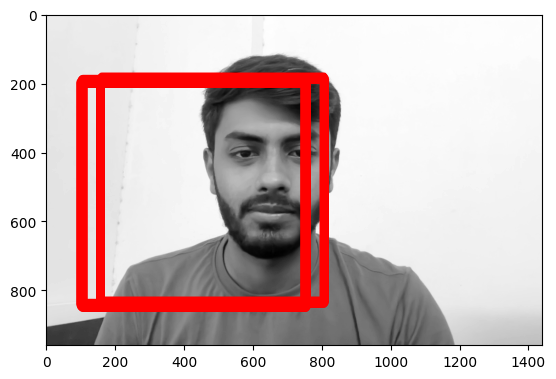

In [36]:
# Function to calculate the sum
def sum_region(integral_image, x, y, w, h):
    return integral_image[y + h, x + w] - integral_image[y, x + w] - integral_image[y + h, x] + integral_image[y, x]

# Functions for Haar features
def haar_feature(integral_image, x, y, w, h):
    half_h = h // 2
    white_region = sum_region(integral_image, x, y, w, half_h)
    black_region = sum_region(integral_image, x, y+half_h, w, h)
    return abs(black_region - white_region)

def haar_vertical_feature(integral_image, x, y, w, h):
    part_w = w // 3
    black_region1 = sum_region(integral_image, x, y, part_w, h)
    white_region = sum_region(integral_image, x + part_w, y, part_w, h)
    black_region2 = sum_region(integral_image, x + 2 * part_w, y, part_w, h)
    return abs((black_region1 + black_region2) - (white_region * 2))



def composite_haar_feature(integral_image, x, y, w, h):

    # trying to create a face like structure of haar filters

    eye_height = h // 6
    nose_height = h // 6
    lip_height = h // 6

    eye_width = w // 4
    lip_width = w // 3

    eye_region_1 = (x + eye_width // 2, y, eye_width, eye_height)
    eye_region_2 = (x + (w - eye_width // 2 - eye_width), y, eye_width, eye_height)
    nose_region = (x + w // 2 - eye_width // 2, y + eye_height, eye_width, nose_height)
    lip_region_1 = (x + (w - lip_width) // 2, y + eye_height + nose_height, lip_width, lip_height)
    lip_region_2 = (x + (w - lip_width) // 4, y + eye_height + nose_height + lip_height, lip_width, lip_height)
    lip_region_3 = (x + (3 * (w - lip_width) // 4), y + eye_height + nose_height + lip_height, lip_width, lip_height)

    eye_feature_1 = haar_feature(integral_image, *eye_region_1)
    eye_feature_2 = haar_feature(integral_image, *eye_region_2)
    nose_feature = haar_vertical_feature(integral_image, *nose_region)
    # lip_feature_1 = haar_feature(integral_image, *lip_region_1)
    lip_feature_2 = haar_feature(integral_image, *lip_region_2)
    # lip_feature_3 = haar_feature(integral_image, *lip_region_3)

    lip_feature_1 = 0
    lip_feature_3 = 0

    combined_feature_value = (eye_feature_1 + eye_feature_2 + nose_feature + lip_feature_1 + lip_feature_2 + lip_feature_3)
    return combined_feature_value

# Function to plot the detection
def visualize_detections(image, detections):
    plt.imshow(image, cmap='gray')
    for (_ ,x, y, w, h) in detections:
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=1))
    plt.show()

# Function to detect the face
def detect_faces(integral_image, window_size, step_size):
    detections = []
    for y in range(0, integral_image.shape[0] - window_size[1], step_size):
        for x in range(0, integral_image.shape[1] - window_size[0], step_size):
            value = composite_haar_feature(integral_image, x, y, *window_size)
            detections.append((value,x, y, *window_size))
    return detections

detections = detect_faces(integral_image, (650, 650), 1)
detections.sort(reverse=True)
detections

visualize_detections(img, detections[:1000])

# **Question-2**

# **(a)**

In [39]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

# Function to load the dataset
def load_dataset(base_path):
    images = []
    labels = []

    # Load real images with label 0
    real_path = os.path.join(base_path, 'real')
    for img_name in os.listdir(real_path):
        img_path = os.path.join(real_path, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (64, 64))  # Resize images
        images.append(image)
        labels.append(0)  # Label 0 for real

    # Load spoof images with label 1
    spoof_path = os.path.join(base_path, 'spoof')
    for img_name in os.listdir(spoof_path):
        img_path = os.path.join(spoof_path, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (64, 64))  # Resize images
        images.append(image)
        labels.append(1)  # Label 1 for spoof

    return np.array(images), np.array(labels)

# Preprocess and flatten the images
def preprocess_images(images):
    return images.reshape(images.shape[0], -1)  # Flatten the images

# Load dataset
base_path = "/content/drive/MyDrive/Computer Vision/Assignment-2/dataset"
images, labels = load_dataset(base_path)
images_flat = preprocess_images(images)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(images_flat, labels, test_size=0.2, random_state=42)

# Train SVM classifier
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:")
print(accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy:
0.530562347188264
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.53      0.55       218
           1       0.50      0.53      0.51       191

    accuracy                           0.53       409
   macro avg       0.53      0.53      0.53       409
weighted avg       0.53      0.53      0.53       409

Confusion Matrix:
[[116 102]
 [ 90 101]]


# **(b)**

In [42]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the dataset
def load_dataset(base_path):
    images = []
    labels = []

    # Load real images
    real_path = os.path.join(base_path, 'real')
    for img_name in os.listdir(real_path):
        img_path = os.path.join(real_path, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (64, 64))  # Resize images
        images.append(image)
        labels.append(0)  # Label 0 for real

    # Load spoof images
    spoof_path = os.path.join(base_path, 'spoof')
    for img_name in os.listdir(spoof_path):
        img_path = os.path.join(spoof_path, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (64, 64))  # Resize images
        images.append(image)
        labels.append(1)  # Label 1 for spoof

    return np.array(images), np.array(labels)

# Function to compute LBP features
def compute_lbp_scratch(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Get image dimensions
    height, width = gray.shape

    # Initialize LBP array
    lbp_image = np.zeros_like(gray, dtype=np.uint8)

    # Define the offsets for the 8 surrounding pixels
    offsets = [(-1, -1), (-1, 0), (-1, 1),
               (0, -1),           (0, 1),
               (1, -1), (1, 0), (1, 1)]

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            center = gray[i, j]
            lbp_value = 0

            for k, (dx, dy) in enumerate(offsets):
                # Compare center pixel with surrounding pixels
                neighbor = gray[i + dx, j + dy]
                lbp_value |= (neighbor > center) << k

            lbp_image[i, j] = lbp_value

    return lbp_image

# Function to compute LBP features
def compute_lbp(images):
    lbp_features = []
    for img in images:
        lbp_image = compute_lbp_scratch(img)
        # Calculate the histogram of LBP
        (hist, _) = np.histogram(lbp_image.ravel(), bins=np.arange(0, 11), density=True)
        lbp_features.append(hist)
    return np.array(lbp_features)

# Load dataset
base_path = "/content/drive/MyDrive/Computer Vision/Assignment-2/dataset"
images, labels = load_dataset(base_path)

# Compute LBP features
lbp_features = compute_lbp(images)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(lbp_features, labels, test_size=0.2, random_state=42)

# Train SVM classifier
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:")
print(accuracy_score(y_test, y_pred))
print("Classification Report for LBP:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix for LBP:")
print(confusion_matrix(y_test, y_pred))

Accuracy:
0.5330073349633252
Classification Report for LBP:
              precision    recall  f1-score   support

           0       0.53      1.00      0.70       218
           1       0.00      0.00      0.00       191

    accuracy                           0.53       409
   macro avg       0.27      0.50      0.35       409
weighted avg       0.28      0.53      0.37       409

Confusion Matrix for LBP:
[[218   0]
 [191   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **(c)**

In [41]:
import os
import numpy as np
import cv2
from scipy.ndimage import convolve
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
def load_dataset(base_path):
    images = []
    labels = []

    # Load real images
    real_path = os.path.join(base_path, 'real')
    for img_name in os.listdir(real_path):
        img_path = os.path.join(real_path, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (64, 64))  # Resize images
        images.append(image)
        labels.append(0)  # Label 0 for real

    # Load spoof images
    spoof_path = os.path.join(base_path, 'spoof')
    for img_name in os.listdir(spoof_path):
        img_path = os.path.join(spoof_path, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (64, 64))  # Resize images
        images.append(image)
        labels.append(1)  # Label 1 for spoof

    return np.array(images), np.array(labels)

# Define the Sobel filter function
def sobel_filter(image_array):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]])

    # x-direction (vertical edges)
    G_x = convolve(image_array, sobel_x)

    # y-direction (horizontal edges)
    G_y = convolve(image_array, sobel_y)

    # Computing the gradient magnitude (edge intensity)
    gradient_magnitude = np.sqrt(G_x**2 + G_y**2)

    # Clipping the values to be in the range [0, 255] (grey scale)
    gradient_magnitude = np.clip(gradient_magnitude, 0, 255)

    return G_x, G_y, gradient_magnitude

# Define the Prewitt filter function
def prewitt_filter(image_array):
    prewitt_x = np.array([[-1, 0, 1],
                          [-1, 0, 1],
                          [-1, 0, 1]])

    prewitt_y = np.array([[1, 1, 1],
                          [0, 0, 0],
                          [-1, -1, -1]])

    # x-direction (vertical edges)
    G_x = convolve(image_array, prewitt_x)

    # y-direction (horizontal edges)
    G_y = convolve(image_array, prewitt_y)

    # Computing the gradient magnitude (edge intensity)
    gradient_magnitude = np.sqrt(G_x**2 + G_y**2)

    # Clipping the values to be in the range [0, 255] (grey scale)
    gradient_magnitude = np.clip(gradient_magnitude, 0, 255)

    return G_x, G_y, gradient_magnitude

# Function to compute edge features using Sobel and Prewitt
def compute_edge_features(images):
    edge_features = []
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply Sobel filter
        _, _, sobel_gradient = sobel_filter(gray_img)

        # Apply Prewitt filter
        _, _, prewitt_gradient = prewitt_filter(gray_img)

        # Flatten the edge images and concatenate them
        edge_feature = np.hstack((sobel_gradient.flatten(), prewitt_gradient.flatten()))
        edge_features.append(edge_feature)
    return np.array(edge_features)

# Load dataset
base_path = "/content/drive/MyDrive/Computer Vision/Assignment-2/dataset"
images, labels = load_dataset(base_path)

# Compute edge features
edge_features = compute_edge_features(images)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(edge_features, labels, test_size=0.2, random_state=42)

# Train SVM classifier
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:")
print(accuracy_score(y_test, y_pred))
print("Classification Report for Edge Detection:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix for Edge Detection:")
print(confusion_matrix(y_test, y_pred))

Accuracy:
0.5452322738386308
Classification Report for Edge Detection:
              precision    recall  f1-score   support

           0       0.57      0.62      0.59       218
           1       0.51      0.46      0.48       191

    accuracy                           0.55       409
   macro avg       0.54      0.54      0.54       409
weighted avg       0.54      0.55      0.54       409

Confusion Matrix for Edge Detection:
[[136  82]
 [104  87]]
